<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Voronoi_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Modelo de células con distribución espacial__

---

Import stantard libraries for plotting and necessary libraries from `SciPy`

In [771]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.collections import LineCollection

from matplotlib.patches import Polygon

mpl.rcParams['figure.figsize'] = (12,6)

In [772]:
def vpoint_to_xy(vor, index):
    return vor.points[index]

def vpoint_to_region(vor, index):
    return vor.point_region[index]

def region_to_vpoint(vor, index):
    return np.where(vor.point_region == index)[0][0]

In [773]:
def vpoints_to_regions(vor, vpoints):
    regions = []
    for i in vpoints:
        regions.append(vpoint_to_region(vor, i))
    return regions

def regions_to_vpoints(vor, regions):
    vpoints = []
    for i in regions:
        vpoints.append(region_to_vpoint(vor, i))
    return vpoints

Ahora continuamos al definir las fronteras de nuestra superficie. Como queremos que se asemeje a una estructura acinar, simulamos un medio círculo interior y exterior.

\begin{align}
    \alpha(r, \theta) = r,\qquad\ \theta\in{\{0, \pi\}},\quad  r=\{1, 2\}
\end{align}

\begin{align}
    x &= r\cos\theta,\quad &y &= r\sin\theta\\
    \Rightarrow r &= \sqrt{x^2+y^2},\quad &\theta &= \arctan\left(\frac{y}{x}\right)
\end{align}

In [774]:
### parámetros
tol = 0.02; n_space = 750
theta = np.linspace(0, np.pi, n_space);
r = np.array([1.0, 2.0]);

### funciones
alpha_x = lambda r, theta: r*np.cos(theta);
alpha_y = lambda r, theta: r*np.sin(theta);

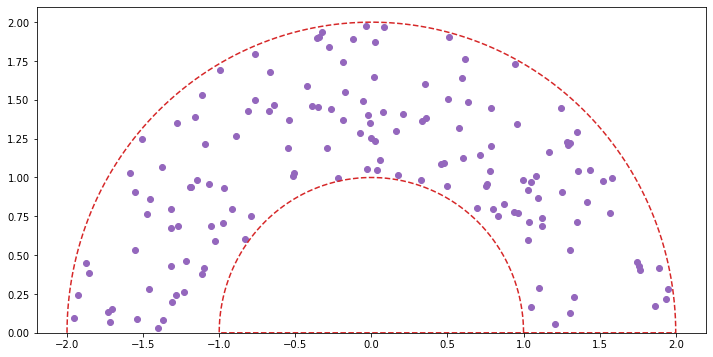

In [775]:
N = 150;
X_border, Y_border = [], []
for i in range(len(r)):
    X_border.append(alpha_x(r[i], theta))
    Y_border.append(alpha_y(r[i], theta))

X_border = np.array(X_border).flatten()
Y_border = np.array(Y_border).flatten()
pts_border = np.array([X_border, Y_border]).T

#----------------------------------------
r_rand     = np.random.rand(N) * abs(r[-1]-r[0]-2*tol) + r[0] + tol
theta_rand = np.random.rand(N) * abs(theta[-1]-theta[0]-2*tol) + theta[0] + tol
# r_rand = np.ones(N) * 1.5;
# theta_rand = np.linspace(tol, np.pi-tol, N);

X_rand = alpha_x(r_rand, theta_rand)
Y_rand = alpha_y(r_rand, theta_rand)
pts_rand = np.array([X_rand, Y_rand]).T

#----------------------------------------
X_base = np.linspace(-r[1], r[1], n_space).flatten()
Y_base = np.zeros(n_space).flatten()-0.1
pts_base = np.array([X_base, Y_base]).T

#----------------------------------------

plt.scatter(X_rand, Y_rand, color="tab:purple")
plt.plot(X_border, Y_border, "--", color="tab:red");
plt.plot(X_base, Y_base, "--", color="tab:red"); 
plt.ylim([0.0,2.1]); plt.show()

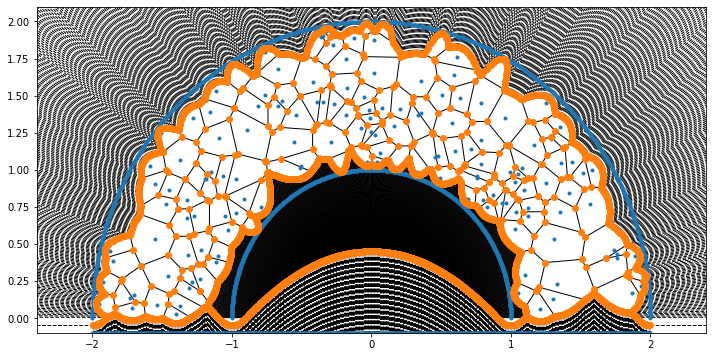

<Figure size 1080x504 with 0 Axes>

In [776]:
total = np.concatenate((pts_rand, pts_border, pts_base))
vor = Voronoi(total)

voronoi_plot_2d(vor)
plt.ylim([-0.1,2.1])
plt.figure(figsize=(15,7))
plt.show()

(-0.1, 2.0)

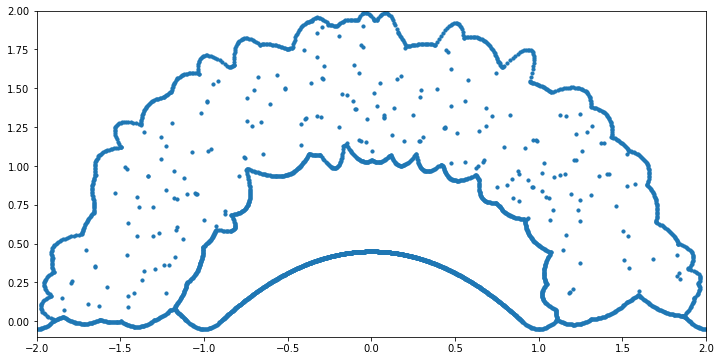

In [777]:
plt.scatter(vor.vertices[:,0], vor.vertices[:,1], s=10)
plt.xlim([-2,2]); plt.ylim([-0.1,2])

*   ###  __Paso $N+1$:__ _Encontrando y discriminando las regiones de Voronoi_



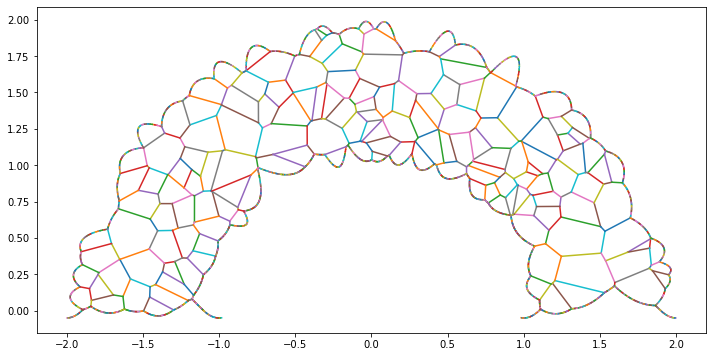

In [778]:
finite_segments = []
for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        finite_segments.append(vor.vertices[simplex])

for i in range(len(finite_segments)):
    x_line = finite_segments[i][:,0]
    y_line = finite_segments[i][:,1]
    r_line = (x_line**2 + y_line**2)**(1/2)
    if (np.min(r_line)>= r[0]-tol) and (np.max(r_line)<= r[1]+tol) and (np.min(y_line) >= -0.15):
        plt.plot(x_line, y_line)

In [779]:
def get_polygons(vor):
    Polygons, regions = [], []
    nregions = len(vor.regions)
    for i in range(nregions-1):
        if (not -1 in vor.regions[i]) and (len(vor.regions[i]) >=1):
            x_ = np.array([vor.vertices[k][0] for k in vor.regions[i]])
            y_ = np.array([vor.vertices[k][1] for k in vor.regions[i]])
            r_ = (x_**2+y_**2)**(1/2)
            if (np.min(r_) >= r[0] - tol) and (np.max(r_) <= r[1] + tol):
                polygon = np.array([vor.vertices[k] for k in vor.regions[i]])
                Polygons.append(np.array([*zip(*polygon)]))
                regions.append(i)
    vpoints = regions_to_vpoints(vor, regions)
    Polygons = [x for _,x in sorted(zip(vpoints, Polygons))]

    return Polygons

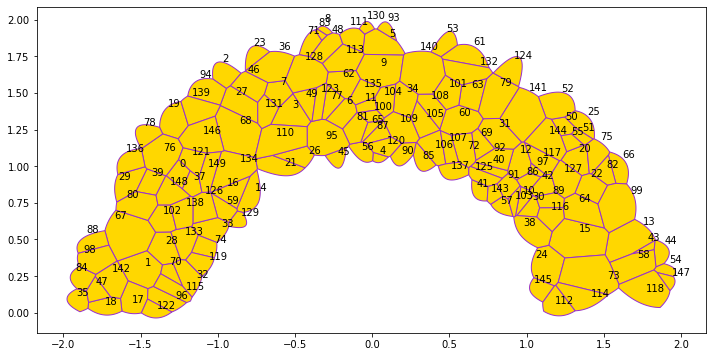

In [780]:
### make up data points
points = np.random.rand(15,2)

### compute Voronoi tesselation
vor = Voronoi(total)

### get Voronoi regions
Polygons = get_polygons(vor)

### visualize Voronoi regions
for i in range(len(Polygons)):
    polygon = Polygons[i]
    X, Y = polygon
    plt.text(np.mean(X), np.mean(Y) + 0.05, f"{i}")
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")
plt.show()

In [781]:
len(Polygons)           # Número de polígonos guardados (coincide con el número de puntos dados)
# x[i] -> Polygons[i][0]
# y[i] -> Polygons[i][1]

150


*   ###  __Paso $N+2$:__ _Calculando el área y el centroide de un polígono_

\begin{align}
    A &= \frac{1}{2}\sum_{i=0}^{N-1} (x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Y para el cálculo de las coordenadas del centro de masas en 2D tenemos las siguientes ecuaciones

\begin{align}
    C_x &= \frac{1}{6A}\sum_{i=0}^{N-1}(x_i+x_{i+1})(x_iy_{i+1}-x_{i+1}y_i) \\
    C_y &= \frac{1}{6A}\sum_{i=0}^{N-1}(y_i+y_{i+1})(x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Para mayor información puede consultar el siguiente enlace: [Calculating the area and centroid of a polygon. By Paul Bourke](https://lexrent.eu/wp-content/uploads/torza/artikel_groep_sub_2_docs/BYZ_3_Polygon-Area-and-Centroid.pdf)

-----

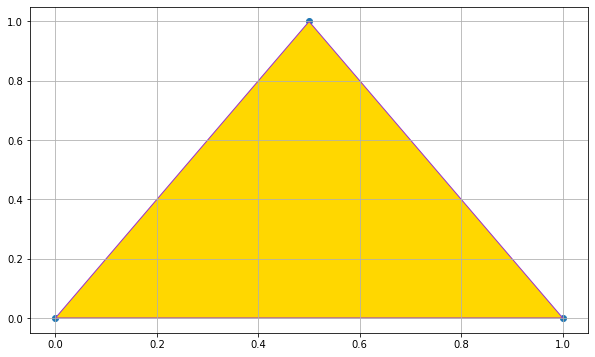

In [782]:
x_prueba = np.array([0,1,0.5])
y_prueba = np.array([0,0,1])

polygon_prueba = np.array([x_prueba, y_prueba])

plt.figure(figsize=(10,6))
plt.scatter(x_prueba, y_prueba); plt.fill(x_prueba, y_prueba, edgecolor="darkorchid", facecolor="gold")
plt.grid()

In [783]:
def get_area(polygon):
    n_area = polygon.shape[1]
    X, Y = polygon
    S = np.empty(n_area)
    
    for i in range(n_area):
        S[i] = X [i]*Y[(i+1) % n_area] - X[(i+1) % n_area]*Y[i]
    return abs((1/2)*np.sum(S))

get_area(polygon_prueba)

0.5

In [784]:
def area_voronoi(Polygons):
    S = np.empty(len(Polygons))

    for i in range(len(S)):
        S[i] = get_area(Polygons[i])
    return S

area_voronoi(Polygons)

array([0.01608198, 0.04772726, 0.02140673, 0.03298176, 0.00453293,
       0.0340002 , 0.02305189, 0.02161363, 0.00335096, 0.05453427,
       0.01029924, 0.00940172, 0.02598097, 0.05618148, 0.02547407,
       0.07813476, 0.02384975, 0.02992057, 0.02081985, 0.03257391,
       0.02406244, 0.02813921, 0.0266796 , 0.01382586, 0.04245129,
       0.01899547, 0.02048228, 0.03437893, 0.03288432, 0.02856569,
       0.01198045, 0.03769697, 0.02589872, 0.02621799, 0.02752205,
       0.01619164, 0.04342358, 0.01397092, 0.03636765, 0.02048459,
       0.01123617, 0.01125756, 0.01679557, 0.00452927, 0.01271039,
       0.01096208, 0.02829341, 0.01496021, 0.02311962, 0.01825235,
       0.01221067, 0.00729593, 0.03285538, 0.01696474, 0.00780535,
       0.00996989, 0.01453313, 0.01143428, 0.04278921, 0.01660833,
       0.04130884, 0.02829437, 0.0294487 , 0.02618215, 0.04038319,
       0.00749601, 0.01856962, 0.07607075, 0.06886531, 0.0168331 ,
       0.01037878, 0.01488415, 0.02593628, 0.07602223, 0.01669

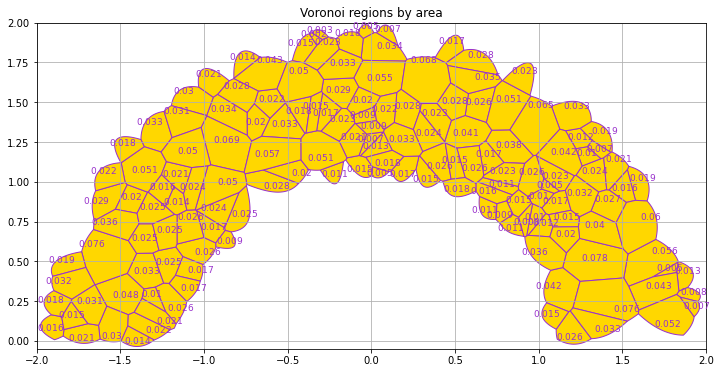

In [785]:
A_vor = area_voronoi(Polygons)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(np.mean(X), np.mean(Y), f'${num_label}$', fontsize=9, horizontalalignment='center', color='darkorchid', fontweight='bold')
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")

plt.title("Voronoi regions by area")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

---

Ahora se calcula el centroide de cada polígono

In [786]:
def get_centroid(polygon, tol = 0.05):
    n_centroid = polygon.shape[1]
    X, Y = polygon
    CX, CY = np.empty([2, n_centroid])
    A = get_area(polygon)
    
    for i in range(n_centroid):
        CX[i] = (X[i] + X[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
        CY[i] = (Y[i] + Y[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
     
    cX, cY = (np.sum(CX), np.sum(CY))/(6*A) 
    if abs(cX - np.mean(X)) > abs(-cX - np.mean(X)):
        cX = -cX
    if abs(cY - np.mean(Y)) > abs(-cY - np.mean(Y)):
        cY = -cY
    return cX, cY

get_centroid(polygon_prueba)

(0.5, 0.3333333333333333)

In [787]:
def centroid_voronoi(Polygons):
    C = np.empty([2, len(Polygons)])
    for i in range(C.shape[1]):
        C[:,i] = get_centroid(Polygons[i])
    return C

centroid_voronoi(Polygons);

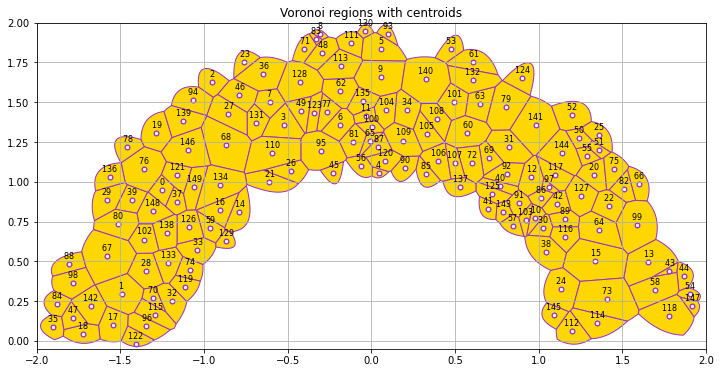

In [788]:
C_vor = centroid_voronoi(Polygons);

fig, ax = plt.subplots();

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(get_area(Polygons[i]), 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.035, f'${i}$', fontsize=8, horizontalalignment='center', color='black', fontweight='bold')
    ax.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
ax.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=1, s=25)
ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=2, s=5)

plt.title("Voronoi regions with centroids")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

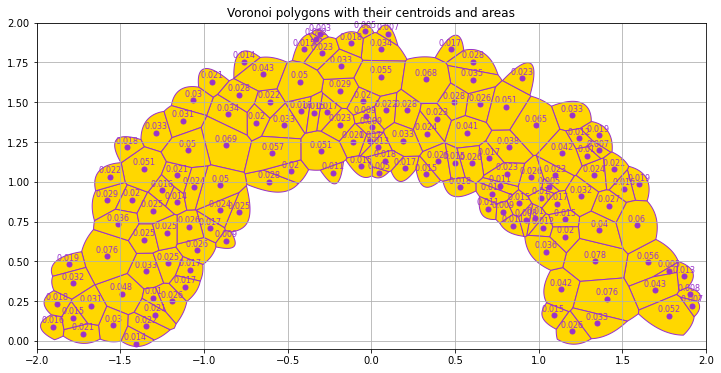

In [789]:
A_vor = area_voronoi(Polygons);
C_vor = centroid_voronoi(Polygons);

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=8, horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=0, s=5)
plt.title("Voronoi polygons with their centroids and areas")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

*   ###  __Paso $N+3$:__ _Definiendo las interacciones y evolución del sistema a partir del potencial $V(\vec{x},t)$_

\begin{align}
    V(\vec{r_i}, t) = \frac{K_v}{2}\left(A_i(t)-A_0(t)\right)^2 + \frac{K_c}{2}\big|\vec{r}_i(t) - \vec{r}_{0,i}(t)\big|^2 
\end{align}

donde $A_0 = \sum_{i=1}^N(A_i/N)$

[Cell Patterns Emerge from Coupled Chemical and Physical Fields with Cell Proliferation Dynamics: The Arabidopsis thaliana Root as a Study System](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3642054/)

\begin{align}
    A_{1/2,dona} &= \frac{\pi}{2} \left(r_{max}^2-r_{min}^2\right)\\
    \Rightarrow A_0 &= \lim_{t\to\infty} A_i(t)=\frac{A_{1/2,dona}}{N_{reg}} = \frac{\pi}{2N} \left(r_{max}^2-r_{min}^2\right)
\end{align}

In [790]:
A_dona = (np.pi/2)*(r[1]**2 - r[0]**2)
A_0 = A_dona/len(Polygons)
A_0

0.031415926535897934

In [791]:
K_v, K_c = 1, 1

# (K_v/2)*(A_vor-A_0)**2                # evolución estática
(K_v/2)*(A_vor-np.mean(A_vor))**2;    # evolución dinámica

In [792]:
def dist_vor(pts_vor, C_vor):
    dist, index = [], []
    for i in range(len(pts_vor)):
        s = pts_rand[i].reshape([2,1])
        dist.append(np.min(np.sum((C_vor - s)**2, axis=0)))
        index.append(np.argmin(np.sum((C_vor - s)**2, axis=0)))

    return np.array(dist), np.array(index), 

dist_vor(pts_rand, C_vor)[1]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        43,  14,  15,  16,  17,  18,  19,  20,  26,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,   0,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  43,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  83,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 108, 107, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 147, 119, 120, 121, 122, 123, 124,  40, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

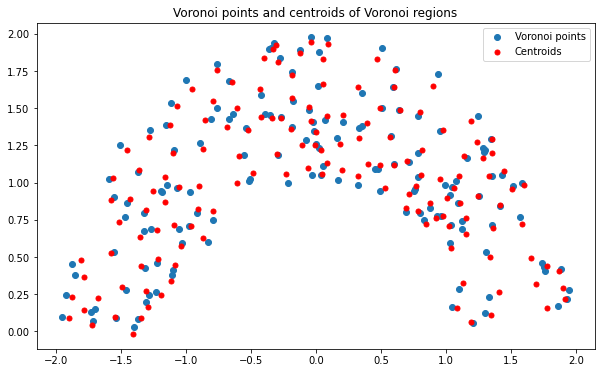

In [793]:
plt.figure(figsize=(10,6))
plt.scatter(pts_rand.T[0],pts_rand.T[1], label="Voronoi points")
plt.scatter(C_vor[0], C_vor[1], color="red", s=25, label="Centroids")
plt.title("Voronoi points and centroids of Voronoi regions"); plt.legend()

In [794]:
K, A_0 = [1, 1], (np.pi/2)*(r[1]**2 - r[0]**2)/len(Polygons)

def potential_vor(K, pts_vor, A_vor, C_vor):
    V = np.empty(len(pts_vor))
    dist, index = dist_vor(pts_vor, C_vor)

    # v1 = ((K[0]/2)*(A_vor-A_0)**2)[index]               # evolución estática
    v1 = ((K[0]/2)*(A_vor-np.mean(A_vor))**2)[index]
    v2 = (K[1]/2)*dist
    return v1 + v2

potential_vor(K, pts_rand, A_vor, C_vor);

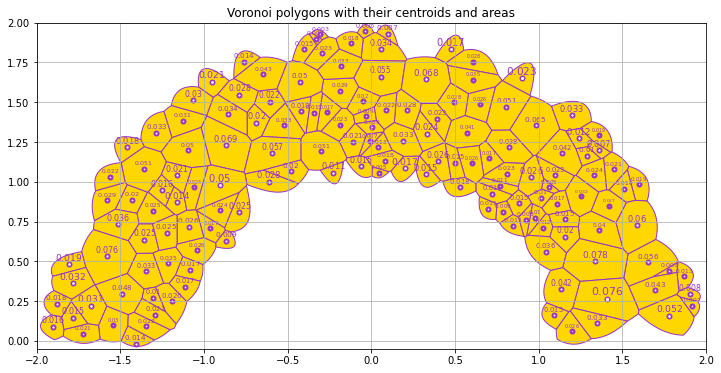

In [795]:
V_vor = potential_vor(K, pts_rand, A_vor, C_vor)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=np.sqrt(V_vor[i])*100+4, horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*1000)

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); 
plt.title("Voronoi polygons with their centroids and areas")
plt.xlim([-2.0, 2.0]); plt.ylim([-0.05, 2.0])
plt.grid()

\begin{align}
    F_x(x_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(x_i-x_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(x_i-x_{0,i})\\
    F_y(y_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(y_i-y_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(y_i-y_{0,i})  
\end{align}

In [796]:
def get_lines(vor):
    line_segments, line_regions = [], []
    for simplex, pointidx in zip(vor.ridge_vertices, vor.ridge_points):
        if -1 not in simplex:
            pointidx = np.asarray(pointidx)
            simplex = np.asarray(simplex)
            if np.all(pointidx <= len(pts_rand)-1):
                line_segments.append(vor.vertices[simplex])
                line_regions.append(pointidx)
    # line_segments.sort()
    line_segments = np.array(line_segments)
    line_regions = np.array(line_regions)
    return line_segments, line_regions

get_lines(vor)[0], get_lines(vor)[1];

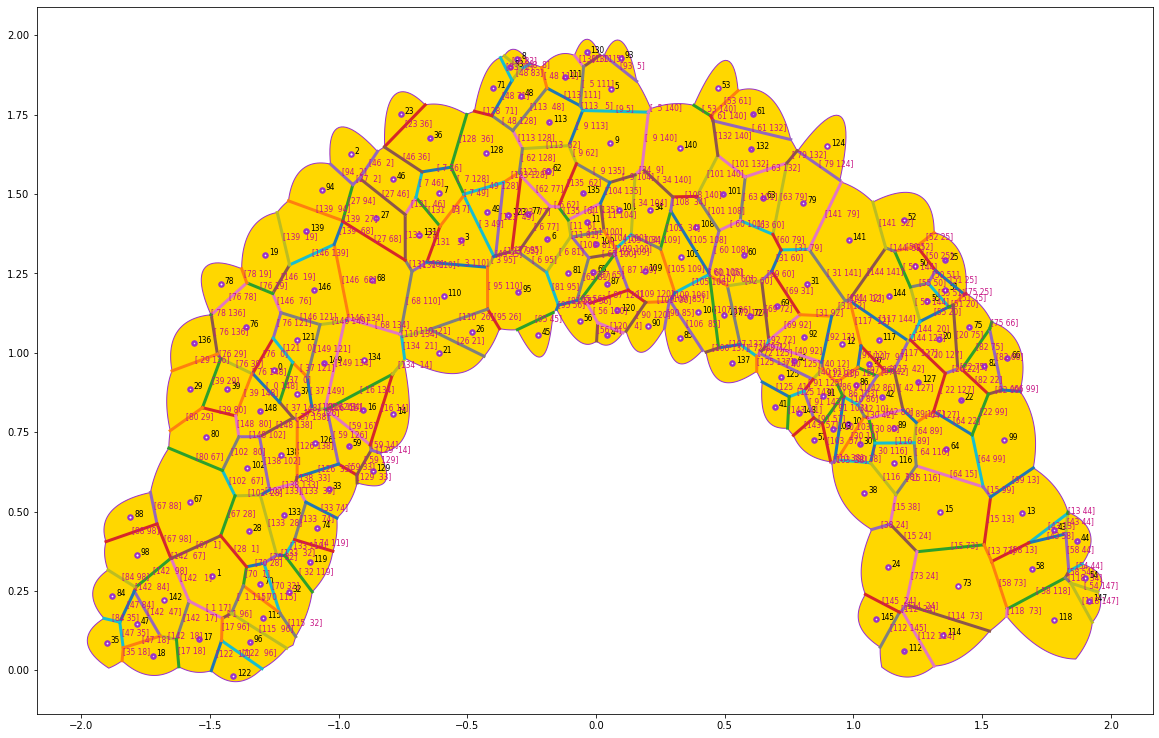

In [800]:
Line_segments, Line_regions = get_lines(vor)
plt.figure(figsize=(20,13))

### Plot shared lines 
for i in range(len(Line_segments)):
    line_segment = Line_segments[i]
    x_line = line_segment[:,0]
    y_line = line_segment[:,1]
    plt.plot(x_line, y_line, linewidth=3)
    plt.text(np.mean(x_line), np.mean(y_line), f"{Line_regions[i]}", color="mediumvioletred", zorder=2, fontsize=7.5)

### Visualize Voronoi regions
for i in range(len(Polygons)):
    X, Y = Polygons[i]
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.text(C_vor[0,i]+0.015, C_vor[1,i], f"{i}", color="black", zorder=0, fontsize=7.5)
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*500)
plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=30); 

{(117, 144): 0.06695969756042164, (12, 117): 0.021775272728512412, (42, 117): 0.0012057107586675015, (97, 117): 0.01535514956385307, (117, 127): 0.01147284542652294, (19, 146): 0.012437877309016573, (76, 146): 0.00465569495775301, (121, 146): 0.024447080446702435, (146, 149): 0.009229904303589392, (139, 146): 0.03418527848093695, (134, 146): 0.0003562577920128741, (68, 146): 0.0584668946619386, (75, 82): 0.02791193391259774, (22, 82): 0.016869125485315925, (66, 82): 0.039355369906508716, (82, 99): 0.003017245806001559, (63, 132): 0.0282922591907228, (63, 101): 0.019199248372837867, (63, 79): 0.05362283286937865, (60, 63): 0.01800940481167113, (12, 97): 0.004689861445376378, (42, 97): 0.0012402824012604401, (86, 97): 0.006288869911290672, (31, 69): 0.030823091215364397, (60, 69): 0.0024658246964605448, (69, 72): 0.035973187682627, (69, 92): 0.021201341857364504, (31, 141): 0.04586336378277879, (12, 31): 0.005146643469794752, (31, 79): 0.011711382900616154, (31, 60): 0.005769495390643981

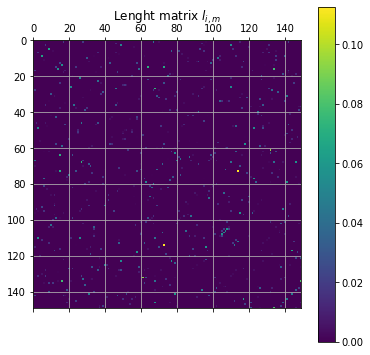

In [801]:
s = (len(Polygons), len(Polygons))
empty_matrix = np.zeros(s)
dist_dict = {}
for k in range(len(Line_regions)):
    i, m = sorted(Line_regions[k])
    d = np.sum((Line_segments[k][0]-Line_segments[k][1])**2)
    empty_matrix[i,m] += d
    empty_matrix[m,i] += d
    # dist_dict[f"{i},{m}"] = d
    dist_dict[(i,m)] = d

plt.matshow(empty_matrix);
plt.xlim([0,len(Polygons)-1]); plt.ylim([len(Polygons)-1,0]);
plt.title("Lenght matrix $l_{i,m}$"); plt.colorbar(); plt.grid()
print(dist_dict)